## Instructions: ##
  
1) Place this file at the root of the folder you started jupyter notebook in.  
2) Create a "data/" folder containing all turnstile data you want to parse.  

_Example Structure:_  
~~~~
/MTA_data_parser.ipynb  
/data  
/data/turnstile_180922.txt
~~~~

In [13]:
from multiprocessing.pool import ThreadPool
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd
import pickle
import datetime
import requests
%matplotlib inline
sns.set()

# Put filepath here
data_path = 'data/'
fp = data_path + 'turnstile_180922.txt'
df = pd.read_csv(fp)
df = df.rename(columns=lambda x: x.strip())

In [ ]:
# Download all log files given range

def gen_dates(start, end, days_between):
    '''Use datetime module to generate a list of dates yymmdd format given a start range,
    end range, and the num of days in between each date (start range is the base)
    :start: array of [int(year), int(mon), int(day)] specifying base start date
    :end: array of [int(year), int(mon), int(day)] specifying end date of range
    :days_between: how many days between each date (starting with start date), default = 7'''
    
    start = datetime.datetime(*start)
    end = datetime.datetime(*end)
    step = datetime.timedelta(days=days_between)
    dates = []
    
    while start < end:
        dates.append(start.strftime('%y%m%d'))
        start += step
    return dates

def download_logs(date):
    '''Given date input, download log file from MTA url:
    :date: a date str yymmdd'''
    
    print('Downloading', 'turnstile_' + date + '.txt')
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'.format(date)
    response = requests.get(url)
    open('data/turnstile_' + date + '.txt', 'wb').write(response.content)

def parallel_dl(dates, threads = 8):
    '''Paralellize downloads to n threads
    :threads: number of concurrent download threads (default is 8)'''
    results = ThreadPool(threads).imap_unordered(download_logs, dates)

start = [2015,1,3]
end = [2018,9,23]
days_between = 7
dates = gen_dates(start, end, days_between)
# parallel_dl(dates)


In [ ]:
# Use to do preliminary inspection of data

def data_inspect(df, resampled=False):
    '''Preliminary inspection of data attributes.
    :resampled: If this is set to true, the data has been cleaned and some cols
    removed/added. Treat differently'''
    
    print("Summarize NAs:")
    print(df.isna().sum())
    
    u_station = df['STATION'].unique()
    print("\nNum Unique Stations:", len(u_station))
    print(u_station)
    
    u_desc = df['DESC'].unique()
    print("\n Unique Descriptions")
    print(u_desc)
    
    if resampled:
        print("\nUnique Time Vals per station")
        for s in u_station:
            u_time = df[df['STATION'] == s]['DATETIME'].unique()
            print('Station:', s)
            print(u_time, '\n')

    else:
        print("\nUnique Time Vals per station")
        for s in u_station:
            u_time = df[df['STATION'] == s]['TIME'].unique()
            print('Station:', s)
            print(u_time, '\n')

data_inspect(df)

In [ ]:
# Organize data before using diff() to find absolute diff in entries/exits.
# Zero out counter rollovers (discard)
# Aggregate times to ensure 4 hour interval in-between

def clean_data(df, name='stop_data', threshold = 20000):
    '''Clean up dataframe by grouping by correct cols, finding change in counts
    from entries/exits, zeroing out implausible counts. Add a DATETIME column with
    a datetime object for ease of grouping in analysis, and to smooth irregular
    data reporting intervals. All of this is stored and pickled in a dict whose key
    is the unique station name, and value is a df with cols C/A, STATION, UNIT,
    SCP, DATE, TIME.
    :df: input raw df data to be cleaned
    :name: string for name of pickle dictionary that will be outputted
    :threshold: a threshold to throw away any |value| greater than '''
    
    stop_data = {}
    u_station = df['STATION'].unique()
    
    group_order = ['C/A', 'STATION', 'UNIT', 'SCP', 'DATE', 'TIME']
    # Sort by Control Area (station), Unit (Remote unit), SCP (turnstile), Date, Time
    df = df.sort_values(by=group_order)
    
    # Substract next row by prev row for magnitude of change
    df['DIFF_ENTRY'] = df['ENTRIES'].diff()
    
    # Add datetime col to resample data
    df['DATETIME'] = df['DATE'] + ' ' + df['TIME']
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    
    # Zero out turnstile errors/rollovers
#     df.loc[(df['DIFF_ENTRY'] < 0) & (df['DIFF_ENTRY'] > -threshold), 'DIFF_ENTRY'] = 
    df.loc[df['DIFF_ENTRY'] > 4000, 'DIFF_ENTRY'] = 0
    
    for s in u_station:
        stop_data[s] = df[df['STATION'] == s][['C/A', 'UNIT', 'SCP', 'DIFF_ENTRY', 'DATETIME']]
    
    pickle.dump(stop_data,open(name, 'wb'))
    print('Done')
clean_data(df, name)

Saving graph to: data/mygraph.svg


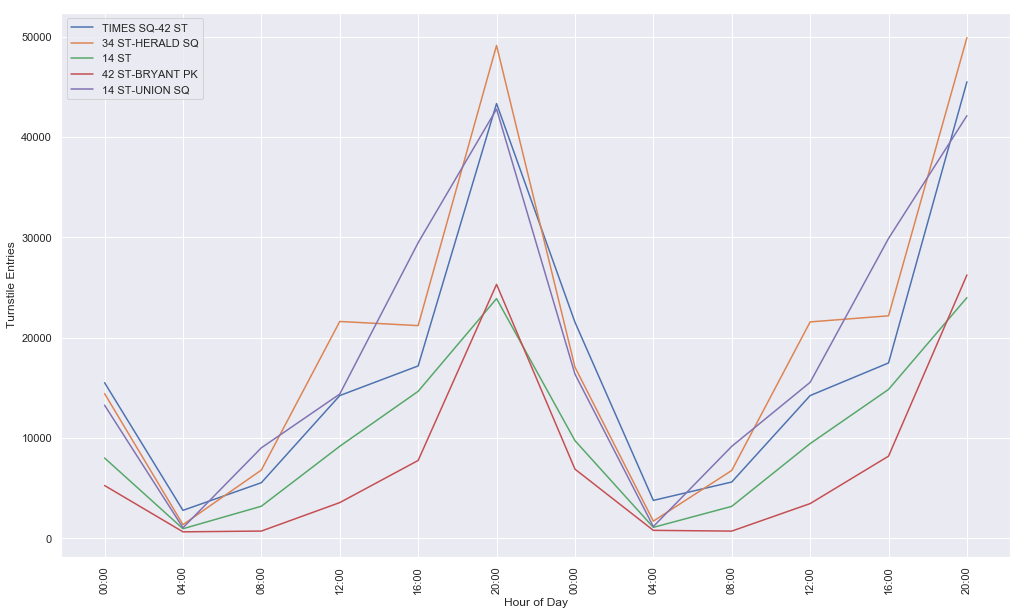

In [42]:
def plot_stop_data(fn, stops, date_range=None, rule="4H", save=False):
    ''' Load and plot entry counts in pickled file containing dictionary with
    stop names as keys, and dataframe with columns C/A, UNIT, SCP, DIFF_ENTRY, DATETIME.
    :fn: this is the filename within the specified data dir above
    :stops: stops is an array containing string names of stops of concern
    :date_range: is a list with 2 entries, start date and end date,
    ["yyyy-mm-dd", "yyyy-mm-dd"]. Will be used to limit data range.
    :rule: this is the data aggregating option, default by to sum counts by 1 Day
    :save: give a string name to your graph to be saved as an svg; default does not save'''
    
    data = pickle.load(open(data_path+fn, 'rb'))
    
    # Pre-plot formattings
    plot_dims = (17,10)
    fig, ax = plt.subplots(figsize=plot_dims)
    y_name = 'Turnstile Entries'
    if 'H' in rule:
        x_format = '%H:%M'
        x_name = 'Hour of Day'
    else:
        x_format = '%d/%m/%y'
        x_name = 'Date'
    
    for stop in stops:
        stop_data = data[stop]
        stop_data = stop_data[['C/A', 'UNIT', 'SCP', 'DIFF_ENTRY', 'DATETIME']]
        
        # Slice data to range of concern
        if date_range:
            start_temp = date_range[0].split('-')
            start_temp = [int(x) for x in start_temp]
            end_temp = date_range[1].split('-')
            end_temp = [int(x) for x in end_temp]
            start = datetime.datetime(*start_temp)
            end = datetime.datetime(*end_temp)
            mask = (stop_data['DATETIME'] >= start) & (stop_data['DATETIME'] < end)
            stop_data = stop_data.loc[mask]
        
        # Resample to ensure regular time intervals (sum over irregular time intervals)
        grouped = stop_data.resample(rule, on='DATETIME', base=0).sum()

        # Plot
        date = grouped.index
        amount_entry = grouped['DIFF_ENTRY']
        sns.lineplot(x=date, y=amount_entry, label = stop, ax=ax)
    
    # Set formatting
    ax.set_xticklabels(labels=date, rotation=90)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter(x_format))
    ax.set_xticks(date)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    
    # Save options
    print('Saving graph to:', data_path + save + '.svg')
    plt.savefig(data_path + save + '.svg', format='svg')
    
stops = ['TIMES SQ-42 ST','34 ST-HERALD SQ',  '14 ST', '42 ST-BRYANT PK' , '14 ST-UNION SQ']
date_range = ['2018-5-1', '2018-5-3']
plot_stop_data('all_data_parsed', stops, date_range, rule='4H', save='mygraph')

In [ ]:
def first_last(df):
    # Priyanka's First-Last method
    turnstiles_df = df
    PREV_ENTRIES=turnstiles_df.groupby(['C/A','UNIT','SCP','STATION','DATE']).ENTRIES.first().reset_index()
    LAST=turnstiles_df.groupby(['C/A','UNIT','SCP','STATION','DATE']).ENTRIES.last().reset_index()
    PREV_ENTRIES['LAST']=LAST['ENTRIES']
    PREV_ENTRIES['DAILY']=PREV_ENTRIES['LAST']-PREV_ENTRIES['ENTRIES']
    ST59 = PREV_ENTRIES[PREV_ENTRIES['STATION'] == '59 ST']
    print(ST59.groupby(['DATE']).sum())
    
first_last(df)